https://huggingface.co/learn/audio-course/en/chapter1/preprocessing (ref)

In [ ]:
# !pip install datasets
# !pip install librosa

In [ ]:
from datasets import load_dataset, Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
minds = load_dataset('PolyAI/minds14', 'en-US', split='train')
minds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.w

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})

In [ ]:
minds = minds.cast_column('audio', Audio(sampling_rate=16_000))
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 563
})

In [ ]:
example = minds[0]
example

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
  'array': array([ 1.70562416e-05,  2.18727451e-04,  2.28099874e-04, ...,
          3.43842403e-05, -5.96364771e-06, -1.76846661e-05]),
  'sampling_rate': 16000},
 'transcription': 'I would like to set up a joint account with my partner',
 'english_transcription': 'I would like to set up a joint account with my partner',
 'intent_class': 11,
 'lang_id': 4}

In [ ]:
MAX_DUR_IN_SEC = 20.0

def is_audio_length_inside_range(inp_len):
    return inp_len < MAX_DUR_IN_SEC

In [ ]:
duration_column  = [librosa.get_duration(path=f) for f in minds['path']]
minds = minds.add_column('duration', duration_column)

In [ ]:
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'duration'],
    num_rows: 563
})

In [ ]:
minds = minds.filter(is_audio_length_inside_range, input_columns=['duration'])
minds

Filter:   0%|          | 0/563 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'duration'],
    num_rows: 533
})

In [ ]:
max(minds['duration'])

19.87625

In [ ]:
from transformers import WhisperFeatureExtractor

In [ ]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
feature_extractor

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

WhisperFeatureExtractor {
  "chunk_length": 30,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [ ]:
def prepare_dataset(example):
    audio = example['audio']
    features = feature_extractor(audio['array'], sampling_rate=audio['sampling_rate'], padding=True)
    return features

In [ ]:
minds = minds.map(prepare_dataset)

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

In [ ]:
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'duration', 'input_features'],
    num_rows: 533
})

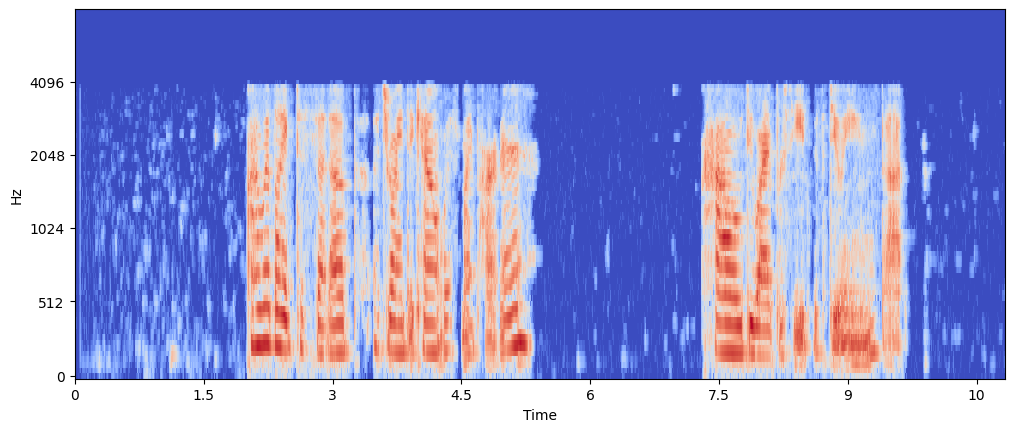

In [ ]:
example = minds[0]
input_features = example['input_features']

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis = 'time',
    y_axis = 'mel',
    sr = feature_extractor.sampling_rate,
    hop_length = feature_extractor.hop_length
);